In [2]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt


In [3]:
def segmentHandRegion(gray):
    # Segment the hand region
    th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    contours, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    hand_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(hand_contour)
    hand_roi = gray[y:y+h, x:x+w]
    return hand_roi

In [19]:
def preProcessing(img):
    # Check if the image is already grayscale
    if len(img.shape) == 2:
        gray = img
    else:
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blurring with a kernel size of 5x5 and sigma of 0
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Resize the image
    resized = cv2.resize(gray, (4*128, 4*64))


    # Apply histogram equalization to enhance the contrast of the image
    hist = cv2.equalizeHist(resized)

    return hist


In [75]:
def adjust_brightness(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [76]:
def remove_shadows(image, mask):
    # Convert the image to grayscale
    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to get a binary image
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Apply a morphological closing operation to fill in small holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Invert the binary image to get a mask
    shadow_mask = cv2.bitwise_not(closed)

    # Resize the shadow mask to match the size of the input mask
    print(mask.shape)
    shadow_mask_resized = cv2.resize(shadow_mask, (mask.shape[1] , mask.shape[0]))

    # Combine the shadow mask with the input mask to get a final mask
    print(shadow_mask_resized.shape)  
    print(mask.shape)
    final_mask = cv2.bitwise_or(shadow_mask_resized, mask)

    # Apply the final mask to the original image to remove the shadows
    result = cv2.bitwise_and(image, image, mask=final_mask)

    return result


In [77]:
def segment_hand(image):
    # Convert the input image to a 3-channel BGR image
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply median blur to remove noise
    blur = cv2.medianBlur(gray, 5)

    # Threshold the image to create a binary mask
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Find the contour of the hand in the binary mask
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]

    # Find the contour with the largest area, which is assumed to be the hand
    if len(contours) > 0:
        hand_contour = max(contours, key=cv2.contourArea)

        # Create a mask for the hand contour
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [hand_contour], 0, 255, -1)

        # Extract the hand from the original image using the mask
        hand = cv2.bitwise_and(image, image, mask=mask)

        # Remove the shadows from the hand using the mask
        hand_no_shadows = remove_shadows(hand, mask)

        # Enhance the brightness of the hand using histogram equalization
        hand_bright = cv2.cvtColor(hand_no_shadows, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(hand_bright)
        y_eq = cv2.equalizeHist(y)

        # Combine the Y channel with the Cr and Cb channels and convert back to BGR
        hand_bright_eq = cv2.merge((y_eq, cr, cb))
        hand_bright_eq_bgr = cv2.cvtColor(hand_bright_eq, cv2.COLOR_YCrCb2BGR)

        # Apply Gaussian blur to smooth the edges of the hand
        hand_blur = cv2.GaussianBlur(hand_bright_eq_bgr, (5,5), 0)

        # Convert the blurred hand to grayscale
        hand_gray = cv2.cvtColor(hand_blur, cv2.COLOR_BGR2GRAY)

        return hand_gray

    else:
        return None


In [88]:
filename = 'images/{}_men ({}).JPG'.format(1, 1)
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
if not img is None:
    brightened_image = adjust_brightness(img, gamma=0.7)
    gray = segment_hand(brightened_image)
if gray is None:
    print("gray is None")

(2592, 4608)
(2592, 4608)
(2592, 4608)


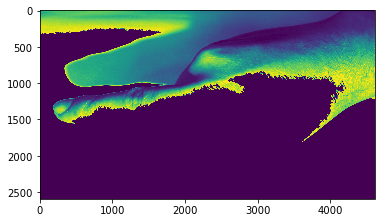

In [89]:
plt.imshow(gray)
plt.show()